# Proyecto Final

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',500)
%matplotlib inline
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV,train_test_split


In [7]:
df = pd.read_excel('SAMPLE_MDL_ACT-1.xlsx',encoding='utf-8').reset_index(drop=True)

df.head()

,ID,TARGET,V_NINC_ATM_3,V_NINC_B_D_OO_3,V_NINC_B_D_TO_3,V_NINC_CH_P_3,V_NINC_OO_R_CTAS_AB_3,V_NINC_OO_R_LC_MAX_3,V_NINC_OO_R_LC_SUM_3,V_NINC_OO_R_SALDO_3,V_NINC_TO_CTAS_AB_3,V_NINC_TO_R_LC_MAX_3,V_NINC_TO_R_LC_SUM_3,V_NINC_TO_R_SALDO_3,V_NINC_TO_SALDO_3,V_NDEC_ATM_3,V_NDEC_B_D_OO_3,V_NDEC_B_D_TO_3,V_NDEC_CH_P_3,V_NDEC_OO_R_CTAS_AB_3,V_NDEC_OO_R_LC_MAX_3,V_NDEC_OO_R_LC_SUM_3,V_NDEC_OO_R_SALDO_3,V_NDEC_TO_CTAS_AB_3,V_NDEC_TO_R_LC_MAX_3,V_NDEC_TO_R_LC_SUM_3,V_NDEC_TO_R_SALDO_3,V_NDEC_TO_SALDO_3,V_VM_ATM0_3,V_VM_B_D_OO0_3,V_VM_B_D_TO0_3,V_VM_CH_P0_3,V_VM_OO_R_CTAS_AB0_3,V_VM_OO_R_LC_MAX0_3,V_VM_OO_R_LC_SUM0_3,V_VM_OO_R_SALDO0_3,V_VM_TO_CTAS_AB0_3,V_VM_TO_R_LC_MAX0_3,V_VM_TO_R_LC_SUM0_3,V_VM_TO_R_SALDO0_3,V_VM_TO_SALDO0_3,V_VM_ATM100_3,V_VM_CH_P100_3,V_VM_OO_R_CTAS_AB1_3,V_VM_OO_R_LC_MAX5000_3,V_VM_OO_R_LC_SUM5000_3,V_VM_OO_R_SALDO1000_3,V_VM_TO_CTAS_AB1_3,V_VM_TO_R_LC_MAX5000_3,V_VM_TO_R_LC_SUM5000_3,V_VM_TO_R_SALDO1000_3,V_VM_TO_SALDO1000_3,V_VM_ATM500_3,V_VM_B_D_OO20_3,V_VM_B_D_TO20_3,V_VM_CH_P500_3,V_VM_OO_R_CTAS_AB2_3,V_VM_OO_R_LC_MAX10000_3,V_VM_OO_R_LC_SUM10000_3,V_VM_OO_R_SALDO10000_3,V_VM_TO_CTAS_AB2_3,V_VM_TO_R_LC_MAX10000_3,V_VM_TO_R_LC_SUM10000_3,V_VM_TO_R_SALDO10000_3,V_VM_TO_SALDO10000_3,V_VM_ATM1500_3,V_VM_B_D_OO45_3,V_VM_B_D_TO45_3,V_VM_CH_P1500_3,V_VM_OO_R_CTAS_AB3_3,V_VM_OO_R_LC_MAX25000_3,V_VM_OO_R_LC_SUM25000_3,V_VM_OO_R_SALDO25000_3,V_VM_TO_CTAS_AB3_3,V_VM_TO_R_LC_MAX25000_3,V_VM_TO_R_LC_SUM25000_3,V_VM_TO_R_SALDO25000_3,V_VM_TO_SALDO25000_3,V_RT_OO_R_LC_SUM_OO_R_CTAS_AB_3,V_RT_TO_R_LC_SUM_TO_CTAS_AB_3,V_RT_TO_R_SALDO_TO_SALDO_3,V_RT_TO_R_SALDO_TO_CTAS_AB_3,V_RT_OO_R_SALDO_OO_R_LC_SUM_3,V_MEDIA_ATM_3,V_MEDIA_B_D_OO_3,V_MEDIA_B_D_TO_3,V_MEDIA_CH_P_3,V_MEDIA_OO_R_CTAS_AB_3,V_MEDIA_OO_R_LC_MAX_3,V_MEDIA_OO_R_LC_SUM_3,V_MEDIA_OO_R_SALDO_3,V_MEDIA_TO_CTAS_AB_3,V_MEDIA_TO_R_LC_MAX_3,V_MEDIA_TO_R_LC_SUM_3,V_MEDIA_TO_R_SALDO_3,V_MEDIA_TO_SALDO_3,V_NINC_ATM_4,V_NINC_B_D_OO_4,V_NINC_B_D_TO_4,V_NINC_CH_P_4,V_NINC_OO_R_CTAS_AB_4,V_NINC_OO_R_LC_MAX_4,V_NINC_OO_R_LC_SUM_4,V_NINC_OO_R_SALDO_4,V_NINC_TO_CTAS_AB_4,V_NINC_TO_R_LC_MAX_4,V_NINC_TO_R_LC_SUM_4,V_NINC_TO_R_SALDO_4,V_NINC_TO_SALDO_4,V_NDEC_ATM_4,V_NDEC_B_D_OO_4,V_NDEC_B_D_TO_4,V_NDEC_CH_P_4,V_NDEC_OO_R_CTAS_AB_4,V_NDEC_OO_R_LC_MAX_4,V_NDEC_OO_R_LC_SUM_4,V_NDEC_OO_R_SALDO_4,V_NDEC_TO_CTAS_AB_4,V_NDEC_TO_R_LC_MAX_4,V_NDEC_TO_R_LC_SUM_4,V_NDEC_TO_R_SALDO_4,V_NDEC_TO_SALDO_4,V_VM_ATM0_4,V_VM_B_D_OO0_4,V_VM_B_D_TO0_4,V_VM_CH_P0_4,V_VM_OO_R_CTAS_AB0_4,V_VM_OO_R_LC_MAX0_4,V_VM_OO_R_LC_SUM0_4,V_VM_OO_R_SALDO0_4,V_VM_TO_CTAS_AB0_4,V_VM_TO_R_LC_MAX0_4,V_VM_TO_R_LC_SUM0_4,V_VM_TO_R_SALDO0_4,V_VM_TO_SALDO0_4,V_VM_ATM100_4,V_VM_CH_P100_4,V_VM_OO_R_CTAS_AB1_4,V_VM_OO_R_LC_MAX5000_4,V_VM_OO_R_LC_SUM5000_4,V_VM_OO_R_SALDO1000_4,V_VM_TO_CTAS_AB1_4,V_VM_TO_R_LC_MAX5000_4,V_VM_TO_R_LC_SUM5000_4,V_VM_TO_R_SALDO1000_4,V_VM_TO_SALDO1000_4,V_VM_ATM500_4,V_VM_B_D_OO20_4,V_VM_B_D_TO20_4,V_VM_CH_P500_4,V_VM_OO_R_CTAS_AB2_4,V_VM_OO_R_LC_MAX10000_4,V_VM_OO_R_LC_SUM10000_4,V_VM_OO_R_SALDO10000_4,V_VM_TO_CTAS_AB2_4,V_VM_TO_R_LC_MAX10000_4,V_VM_TO_R_LC_SUM10000_4,V_VM_TO_R_SALDO10000_4,V_VM_TO_SALDO10000_4,V_VM_ATM1500_4,V_VM_B_D_OO45_4,V_VM_B_D_TO45_4,V_VM_CH_P1500_4,V_VM_OO_R_CTAS_AB3_4,V_VM_OO_R_LC_MAX25000_4,V_VM_OO_R_LC_SUM25000_4,V_VM_OO_R_SALDO25000_4,V_VM_TO_CTAS_AB3_4,V_VM_TO_R_LC_MAX25000_4,V_VM_TO_R_LC_SUM25000_4,V_VM_TO_R_SALDO25000_4,V_VM_TO_SALDO25000_4,V_RT_OO_R_LC_SUM_OO_R_CTAS_AB_4,V_RT_TO_R_LC_SUM_TO_CTAS_AB_4,V_RT_TO_R_SALDO_TO_SALDO_4,V_RT_TO_R_SALDO_TO_CTAS_AB_4,V_RT_OO_R_SALDO_OO_R_LC_SUM_4,V_MEDIA_ATM_4,V_MEDIA_B_D_OO_4,V_MEDIA_B_D_TO_4,V_MEDIA_CH_P_4,V_MEDIA_OO_R_CTAS_AB_4,V_MEDIA_OO_R_LC_MAX_4,V_MEDIA_OO_R_LC_SUM_4,V_MEDIA_OO_R_SALDO_4,V_MEDIA_TO_CTAS_AB_4,V_MEDIA_TO_R_LC_MAX_4,V_MEDIA_TO_R_LC_SUM_4,V_MEDIA_TO_R_SALDO_4,V_MEDIA_TO_SALDO_4,V_NINC_ATM_5,V_NINC_B_D_OO_5,V_NINC_B_D_TO_5,V_NINC_CH_P_5,V_NINC_OO_R_CTAS_AB_5,V_NINC_OO_R_LC_MAX_5,V_NINC_OO_R_LC_SUM_5,V_NINC_OO_R_SALDO_5,V_NINC_TO_CTAS_AB_5,V_NINC_TO_R_LC_MAX_5,V_NINC_TO_R_LC_SUM_5,V_NINC_TO_R_SALDO_5,V_NINC_TO_SALD

## Funciones de ayuda

In [8]:
def miss_u(df,x):
    '''
    df=dataframe
    0<x<1
    return lista de variables que tienen menos missings que x
    '''
    
    aux = df.describe().T[['count']]
    aux/=len(df)
    aux=1-aux
    var_fin = list(aux[aux['count']<=x].reset_index()['index'])
    return var_fin
def percent(df,i=0,o=.01):
    '''
    df=dataframe
    i=decimales de la o en porcentaje
    0<o<1'desde que que percentil se toman los outliers'
    
    return dataframe sin outliers
    '''
    
    c=1-o
    a='%.'+str(i)+'f'
    l_b=a%(o*100)+'%'
    u_b=a%(c*100)+'%'
    aux = df.describe(percentiles=[o,c]).T[[l_b,u_b]]
    aux.reset_index(inplace=True)
    for i,row in aux.iterrows():
        df['ol_%s'%row['index']] = ((df[row['index']]<row[l_b])|
         (df[row['index']]>row[u_b])).astype(int)
    var_ol = [x for x in df.columns if x[:2]=='ol']
    df ['ol'] = (df[var_ol].sum(axis=1)>=1).astype(int)
    af = df[df.ol!=1].copy()
    af = pd.DataFrame(af,columns=df.columns)
    return af
def imputar(df,estrategia='median'):
    '''
    df=dataframe
    estrategia=['mean','median','most_frequent'], por default median
    return datframe con estrategia imputada
    '''
    
    from sklearn.preprocessing import Imputer
    im = Imputer(strategy='median')
    im.fit(df)
    df_1 = pd.DataFrame(im.transform(df),columns=df.columns)
    return df_1
def unico(lista):
    '''
    lista=lista
    return= el valor unico que aparece o indica 'No es único en caso contrario'
    '''
    if len(list(set(lista)))==1:
        return 'Si es unico'
    else:
        return ('No es unico',list(set(lista)))
def woe_code(df,var_disc):
    for v in var_disc:
        aux = df[[v,'ID','TARGET']].copy()
        aux = aux.pivot_table(aggfunc='count',
                              columns='TARGET',
                              fill_value=0,
                              index=v)
        aux = aux['ID']
        aux.reset_index(inplace=True)
        aux

        for i in range(2):
            aux[i]/=aux[i].sum()

        aux['woe'] = np.log(aux[0]/aux[1])
        a=((aux[0]-aux[1])*aux['woe']).sum()
        print "IV variable %s = %.3f " %(v,a)
        if 0.2<=a<=.5:
            df = df.merge(aux[[v,'woe']],on=v,how='inner')
            #df.drop(v,axis=1,inplace=True)
            df.rename(columns={'woe':'W_'+v},inplace=True)
    return df
def metricas(model,Xt,Xv,yt,yv):
    from sklearn.metrics import accuracy_score,roc_auc_score
    print "ROC train:%.3f | ROC test:%.3f " %(roc_auc_score(y_true=yt,y_score=model.predict_proba(Xt)[:,1]),roc_auc_score(y_true=yv,y_score=model.predict_proba(Xv)[:,1]))
    print "ACC train:%.3f | ACC test:%.3f " %(accuracy_score(y_true=yt,y_pred=model.predict(Xt)),accuracy_score(y_true=yv,y_pred=model.predict(Xv)))

## Variables continuas y discretas

In [9]:
var_cont = ['V_RT_OO_R_LC_SUM_OO_R_CTAS_AB_3', 'V_RT_TO_R_LC_SUM_TO_CTAS_AB_3', 'V_RT_TO_R_SALDO_TO_SALDO_3', 'V_RT_TO_R_SALDO_TO_CTAS_AB_3', 'V_RT_OO_R_SALDO_OO_R_LC_SUM_3', 'V_MEDIA_ATM_3', 'V_MEDIA_B_D_OO_3', 'V_MEDIA_B_D_TO_3', 'V_MEDIA_CH_P_3', 'V_MEDIA_OO_R_LC_MAX_3', 'V_MEDIA_OO_R_LC_SUM_3', 'V_MEDIA_OO_R_SALDO_3', 'V_MEDIA_TO_CTAS_AB_3', 'V_MEDIA_TO_R_LC_MAX_3', 'V_MEDIA_TO_R_LC_SUM_3', 'V_MEDIA_TO_R_SALDO_3', 'V_MEDIA_TO_SALDO_3', 'V_RT_OO_R_LC_SUM_OO_R_CTAS_AB_4', 'V_RT_TO_R_LC_SUM_TO_CTAS_AB_4', 'V_RT_TO_R_SALDO_TO_SALDO_4', 'V_RT_TO_R_SALDO_TO_CTAS_AB_4', 'V_RT_OO_R_SALDO_OO_R_LC_SUM_4', 'V_MEDIA_ATM_4', 'V_MEDIA_B_D_OO_4', 'V_MEDIA_B_D_TO_4', 'V_MEDIA_CH_P_4', 'V_MEDIA_OO_R_LC_MAX_4', 'V_MEDIA_OO_R_LC_SUM_4', 'V_MEDIA_OO_R_SALDO_4', 'V_MEDIA_TO_CTAS_AB_4', 'V_MEDIA_TO_R_LC_MAX_4', 'V_MEDIA_TO_R_LC_SUM_4', 'V_MEDIA_TO_R_SALDO_4', 'V_MEDIA_TO_SALDO_4', 'V_RT_OO_R_LC_SUM_OO_R_CTAS_AB_5', 'V_RT_TO_R_LC_SUM_TO_CTAS_AB_5', 'V_RT_TO_R_SALDO_TO_SALDO_5', 'V_RT_TO_R_SALDO_TO_CTAS_AB_5', 'V_RT_OO_R_SALDO_OO_R_LC_SUM_5', 'V_MEDIA_ATM_5', 'V_MEDIA_B_D_OO_5', 'V_MEDIA_B_D_TO_5', 'V_MEDIA_CH_P_5', 'V_MEDIA_OO_R_LC_MAX_5', 'V_MEDIA_OO_R_LC_SUM_5', 'V_MEDIA_OO_R_SALDO_5', 'V_MEDIA_TO_CTAS_AB_5', 'V_MEDIA_TO_R_LC_MAX_5', 'V_MEDIA_TO_R_LC_SUM_5', 'V_MEDIA_TO_R_SALDO_5', 'V_MEDIA_TO_SALDO_5', 'V_RT_OO_R_LC_SUM_OO_R_CTAS_AB_6', 'V_RT_TO_R_LC_SUM_TO_CTAS_AB_6', 'V_RT_TO_R_SALDO_TO_SALDO_6', 'V_RT_TO_R_SALDO_TO_CTAS_AB_6', 'V_RT_OO_R_SALDO_OO_R_LC_SUM_6', 'V_MEDIA_ATM_6', 'V_MEDIA_B_D_OO_6', 'V_MEDIA_B_D_TO_6', 'V_MEDIA_CH_P_6', 'V_MEDIA_OO_R_CTAS_AB_6', 'V_MEDIA_OO_R_LC_MAX_6', 'V_MEDIA_OO_R_LC_SUM_6', 'V_MEDIA_OO_R_SALDO_6', 'V_MEDIA_TO_CTAS_AB_6', 'V_MEDIA_TO_R_LC_MAX_6', 'V_MEDIA_TO_R_LC_SUM_6', 'V_MEDIA_TO_R_SALDO_6', 'V_MEDIA_TO_SALDO_6', 'V_MEDIAN_ATM_7', 'V_MEDIAN_B_D_OO_7', 'V_MEDIAN_B_D_TO_7', 'V_MEDIAN_CH_P_7', 'V_MEDIAN_OO_R_LC_MAX_7', 'V_MEDIAN_OO_R_LC_SUM_7', 'V_MEDIAN_OO_R_SALDO_7', 'V_MEDIAN_TO_R_LC_MAX_7', 'V_MEDIAN_TO_R_LC_SUM_7', 'V_MEDIAN_TO_R_SALDO_7', 'V_MEDIAN_TO_SALDO_7', 'V_ANT_INT_ANTIG', 'V_EDAD_CLIENTE', 'V_LINEA_CRED', 'V_RAT_LC_MO_AVG_1', 'V_RAT_LC_MO_AVG_2', 'V_RAT_LC_MO_AVG_3', 'V_RAT_LC_MO_AVG_4', 'V_RAT_LC_MO_AVG_5', 'V_RAT_LC_MO_AVG_6', 'V_RAT_LC_MO_MAX_1', 'V_RAT_LC_MO_MAX_2', 'V_RAT_LC_MO_MAX_3', 'V_RAT_LC_MO_MAX_4', 'V_RAT_LC_MO_MAX_5', 'V_RAT_LC_MO_MAX_6', 'V_SDO_DEBITO', 'V_BCSCORE', 'V_MO_R__LC_MAX', 'V_OO_R_BANCO_LC_MAX', 'V_MO_R__LC_SUM', 'V_OO_R_BANCO_LC_SUM', 'V_MO_R__SALDO', 'V_OO_R_BANCO_SALDO']

var_disc = [str(x) for x in df.columns if x not in var_cont]

## Tabla Limpia

In [10]:
var_miss=miss_u(df,.3)

var_cont_1=[str(x) for x in var_cont if x in var_miss]+['ID']

var_disc_1=[str(x) for x in var_disc if x in var_miss]

df_cont=df[var_cont_1].copy()
df_disc=df[var_disc_1].copy()

df_cont_1=percent(df_cont,1,.025)[var_cont_1]
df_cont_1=imputar(df_cont_1,'median')

df_cont_1.head()

,V_MEDIA_CH_P_3,V_MEDIA_CH_P_4,V_MEDIA_CH_P_5,V_MEDIA_CH_P_6,V_MEDIAN_CH_P_7,V_ANT_INT_ANTIG,V_EDAD_CLIENTE,V_LINEA_CRED,V_BCSCORE,V_MO_R__LC_MAX,V_OO_R_BANCO_LC_MAX,V_MO_R__LC_SUM,V_OO_R_BANCO_LC_SUM,V_MO_R__SALDO,V_OO_R_BANCO_SALDO,ID
0,2090.990000,1574.1675,1264.060,1057.311667,23.7750,79.0,31.0,10000.0,733.0,10000.0,0.0,10000.0,0.0,4818.0,0.0,251.0
1,8619.693333,8668.7500,9143.118,9993.198333,9928.2550,44.0,44.0,12000.0,681.0,12000.0,10000.0,12000.0,24500.0,2536.0,19228.0,252.0
2,3281.070000,3249.4800,3103.720,2994.146667,1873.3575,0.0,36.0,75000.0,731.0,75000.0,0.0,75000.0,0.0,48812.0,0.0,254.0
3,637.710000,637.7100,637.710,637.710000,637.7100,0.0,57.0,12000.0,733.0,12000.0,17700.0,12000.0,41100.0,8912.0,19708.0,256.0
4,3212.800000,3212.8000,3212.800,3212.800000,3212.8000,181.0,34.0,10000.0,530.0,10000.0,0.0,17000.0,0.0,22583.0,0.0,257.0


## Grafica de variables continuas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdb6cb30d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcdb4160ad0>]], dtype=object)

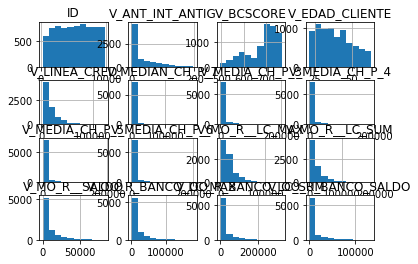

In [11]:
df_cont_1.hist()

## Dataframe final

In [12]:
df_final=pd.merge(df_disc,df_cont_1,how='inner',on='ID')

df_final.head()

,ID,TARGET,V_NINC_ATM_3,V_NINC_B_D_OO_3,V_NINC_B_D_TO_3,V_NINC_CH_P_3,V_NINC_OO_R_CTAS_AB_3,V_NINC_OO_R_LC_MAX_3,V_NINC_OO_R_LC_SUM_3,V_NINC_OO_R_SALDO_3,V_NINC_TO_CTAS_AB_3,V_NINC_TO_R_LC_MAX_3,V_NINC_TO_R_LC_SUM_3,V_NINC_TO_R_SALDO_3,V_NINC_TO_SALDO_3,V_NDEC_ATM_3,V_NDEC_B_D_OO_3,V_NDEC_B_D_TO_3,V_NDEC_CH_P_3,V_NDEC_OO_R_CTAS_AB_3,V_NDEC_OO_R_LC_MAX_3,V_NDEC_OO_R_LC_SUM_3,V_NDEC_OO_R_SALDO_3,V_NDEC_TO_CTAS_AB_3,V_NDEC_TO_R_LC_MAX_3,V_NDEC_TO_R_LC_SUM_3,V_NDEC_TO_R_SALDO_3,V_NDEC_TO_SALDO_3,V_VM_ATM0_3,V_VM_B_D_OO0_3,V_VM_B_D_TO0_3,V_VM_CH_P0_3,V_VM_OO_R_CTAS_AB0_3,V_VM_OO_R_LC_MAX0_3,V_VM_OO_R_LC_SUM0_3,V_VM_OO_R_SALDO0_3,V_VM_TO_CTAS_AB0_3,V_VM_TO_R_LC_MAX0_3,V_VM_TO_R_LC_SUM0_3,V_VM_TO_R_SALDO0_3,V_VM_TO_SALDO0_3,V_VM_ATM100_3,V_VM_CH_P100_3,V_VM_OO_R_CTAS_AB1_3,V_VM_OO_R_LC_MAX5000_3,V_VM_OO_R_LC_SUM5000_3,V_VM_OO_R_SALDO1000_3,V_VM_TO_CTAS_AB1_3,V_VM_TO_R_LC_MAX5000_3,V_VM_TO_R_LC_SUM5000_3,V_VM_TO_R_SALDO1000_3,V_VM_TO_SALDO1000_3,V_VM_ATM500_3,V_VM_B_D_OO20_3,V_VM_B_D_TO20_3,V_VM_CH_P500_3,V_VM_OO_R_CTAS_AB2_3,V_VM_OO_R_LC_MAX10000_3,V_VM_OO_R_LC_SUM10000_3,V_VM_OO_R_SALDO10000_3,V_VM_TO_CTAS_AB2_3,V_VM_TO_R_LC_MAX10000_3,V_VM_TO_R_LC_SUM10000_3,V_VM_TO_R_SALDO10000_3,V_VM_TO_SALDO10000_3,V_VM_ATM1500_3,V_VM_B_D_OO45_3,V_VM_B_D_TO45_3,V_VM_CH_P1500_3,V_VM_OO_R_CTAS_AB3_3,V_VM_OO_R_LC_MAX25000_3,V_VM_OO_R_LC_SUM25000_3,V_VM_OO_R_SALDO25000_3,V_VM_TO_CTAS_AB3_3,V_VM_TO_R_LC_MAX25000_3,V_VM_TO_R_LC_SUM25000_3,V_VM_TO_R_SALDO25000_3,V_VM_TO_SALDO25000_3,V_NINC_ATM_4,V_NINC_B_D_OO_4,V_NINC_B_D_TO_4,V_NINC_CH_P_4,V_NINC_OO_R_CTAS_AB_4,V_NINC_OO_R_LC_MAX_4,V_NINC_OO_R_LC_SUM_4,V_NINC_OO_R_SALDO_4,V_NINC_TO_CTAS_AB_4,V_NINC_TO_R_LC_MAX_4,V_NINC_TO_R_LC_SUM_4,V_NINC_TO_R_SALDO_4,V_NINC_TO_SALDO_4,V_NDEC_ATM_4,V_NDEC_B_D_OO_4,V_NDEC_B_D_TO_4,V_NDEC_CH_P_4,V_NDEC_OO_R_CTAS_AB_4,V_NDEC_OO_R_LC_MAX_4,V_NDEC_OO_R_LC_SUM_4,V_NDEC_OO_R_SALDO_4,V_NDEC_TO_CTAS_AB_4,V_NDEC_TO_R_LC_MAX_4,V_NDEC_TO_R_LC_SUM_4,V_NDEC_TO_R_SALDO_4,V_NDEC_TO_SALDO_4,V_VM_ATM0_4,V_VM_B_D_OO0_4,V_VM_B_D_TO0_4,V_VM_CH_P0_4,V_VM_OO_R_CTAS_AB0_4,V_VM_OO_R_LC_MAX0_4,V_VM_OO_R_LC_SUM0_4,V_VM_OO_R_SALDO0_4,V_VM_TO_CTAS_AB0_4,V_VM_TO_R_LC_MAX0_4,V_VM_TO_R_LC_SUM0_4,V_VM_TO_R_SALDO0_4,V_VM_TO_SALDO0_4,V_VM_ATM100_4,V_VM_CH_P100_4,V_VM_OO_R_CTAS_AB1_4,V_VM_OO_R_LC_MAX5000_4,V_VM_OO_R_LC_SUM5000_4,V_VM_OO_R_SALDO1000_4,V_VM_TO_CTAS_AB1_4,V_VM_TO_R_LC_MAX5000_4,V_VM_TO_R_LC_SUM5000_4,V_VM_TO_R_SALDO1000_4,V_VM_TO_SALDO1000_4,V_VM_ATM500_4,V_VM_B_D_OO20_4,V_VM_B_D_TO20_4,V_VM_CH_P500_4,V_VM_OO_R_CTAS_AB2_4,V_VM_OO_R_LC_MAX10000_4,V_VM_OO_R_LC_SUM10000_4,V_VM_OO_R_SALDO10000_4,V_VM_TO_CTAS_AB2_4,V_VM_TO_R_LC_MAX10000_4,V_VM_TO_R_LC_SUM10000_4,V_VM_TO_R_SALDO10000_4,V_VM_TO_SALDO10000_4,V_VM_ATM1500_4,V_VM_B_D_OO45_4,V_VM_B_D_TO45_4,V_VM_CH_P1500_4,V_VM_OO_R_CTAS_AB3_4,V_VM_OO_R_LC_MAX25000_4,V_VM_OO_R_LC_SUM25000_4,V_VM_OO_R_SALDO25000_4,V_VM_TO_CTAS_AB3_4,V_VM_TO_R_LC_MAX25000_4,V_VM_TO_R_LC_SUM25000_4,V_VM_TO_R_SALDO25000_4,V_VM_TO_SALDO25000_4,V_NINC_ATM_5,V_NINC_B_D_OO_5,V_NINC_B_D_TO_5,V_NINC_CH_P_5,V_NINC_OO_R_CTAS_AB_5,V_NINC_OO_R_LC_MAX_5,V_NINC_OO_R_LC_SUM_5,V_NINC_OO_R_SALDO_5,V_NINC_TO_CTAS_AB_5,V_NINC_TO_R_LC_MAX_5,V_NINC_TO_R_LC_SUM_5,V_NINC_TO_R_SALDO_5,V_NINC_TO_SALDO_5,V_NDEC_ATM_5,V_NDEC_B_D_OO_5,V_NDEC_B_D_TO_5,V_NDEC_CH_P_5,V_NDEC_OO_R_CTAS_AB_5,V_NDEC_OO_R_LC_MAX_5,V_NDEC_OO_R_LC_SUM_5,V_NDEC_OO_R_SALDO_5,V_NDEC_TO_CTAS_AB_5,V_NDEC_TO_R_LC_MAX_5,V_NDEC_TO_R_LC_SUM_5,V_NDEC_TO_R_SALDO_5,V_NDEC_TO_SALDO_5,V_VM_ATM0_5,V_VM_B_D_OO0_5,V_VM_B_D_TO0_5,V_VM_CH_P0_5,V_VM_OO_R_CTAS_AB0_5,V_VM_OO_R_LC_MAX0_5,V_VM_OO_R_LC_SUM0_5,V_VM_OO_R_SALDO0_5,V_VM_TO_CTAS_AB0_5,V_VM_TO_R_LC_MAX0_5,V_VM_TO_R_LC_SUM0_5,V_VM_TO_R_SALDO0_5,V_VM_TO_SALDO0_5,V_VM_ATM100_5,V_VM_CH_P100_5,V_VM_OO_R_CTAS_AB1_5,V_VM_OO_R_LC_MAX5000_5,V_VM_OO_R_LC_SUM5000_5,V_VM_OO_R_SALDO1000_5,V_VM_TO_CTAS_AB1_5,V_VM_TO_R_LC_MAX5000_5,V_VM_TO_R_LC_SUM5000_5,V_VM_TO_R_SALDO1000_5,V_VM_TO_SALDO1000_5,V_VM_ATM500_5,V_VM_B_D_OO20_5,V_VM_B_D_TO20_5,V_VM_CH_P500_5,V_VM_OO_R_CTAS_AB2_5,V_VM_OO_R_LC_MAX10000_5,

In [13]:
df_final.shape

(7731, 340)

## Variables Continuas y Discretas

In [14]:
var_cont_f=[str(x) for x in df_cont_1.columns if x != 'ID']

var_disc_f=[str(x) for x in var_disc_1 if (x!='ID' and x!='TARGET')]

## WOE , IV

In [15]:
af=woe_code(df_final,var_disc_f)

IV variable V_NINC_ATM_3 = 0.066 
IV variable V_NINC_B_D_OO_3 = 0.034 
IV variable V_NINC_B_D_TO_3 = 0.015 
IV variable V_NINC_CH_P_3 = 0.043 
IV variable V_NINC_OO_R_CTAS_AB_3 = 0.000 
IV variable V_NINC_OO_R_LC_MAX_3 = 0.001 
IV variable V_NINC_OO_R_LC_SUM_3 = 0.001 
IV variable V_NINC_OO_R_SALDO_3 = 0.005 
IV variable V_NINC_TO_CTAS_AB_3 = 0.007 
IV variable V_NINC_TO_R_LC_MAX_3 = 0.005 
IV variable V_NINC_TO_R_LC_SUM_3 = 0.012 
IV variable V_NINC_TO_R_SALDO_3 = 0.015 
IV variable V_NINC_TO_SALDO_3 = 0.028 
IV variable V_NDEC_ATM_3 = 0.030 
IV variable V_NDEC_B_D_OO_3 = 0.060 
IV variable V_NDEC_B_D_TO_3 = 0.057 
IV variable V_NDEC_CH_P_3 = 0.042 
IV variable V_NDEC_OO_R_CTAS_AB_3 = 0.025 
IV variable V_NDEC_OO_R_LC_MAX_3 = 0.027 
IV variable V_NDEC_OO_R_LC_SUM_3 = 0.029 
IV variable V_NDEC_OO_R_SALDO_3 = 0.048 
IV variable V_NDEC_TO_CTAS_AB_3 = 0.025 
IV variable V_NDEC_TO_R_LC_MAX_3 = 0.023 
IV variable V_NDEC_TO_R_LC_SUM_3 = 0.031 
IV variable V_NDEC_TO_R_SALDO_3 = 0.060 
IV vari

IV variable V_VM_CH_P500_5 = 0.091 
IV variable V_VM_OO_R_CTAS_AB2_5 = 0.026 
IV variable V_VM_OO_R_LC_MAX10000_5 = 0.117 
IV variable V_VM_OO_R_LC_SUM10000_5 = 0.122 
IV variable V_VM_OO_R_SALDO10000_5 = 0.036 
IV variable V_VM_TO_CTAS_AB2_5 = 0.085 
IV variable V_VM_TO_R_LC_MAX10000_5 = 0.183 
IV variable V_VM_TO_R_LC_SUM10000_5 = 0.187 
IV variable V_VM_TO_R_SALDO10000_5 = 0.049 
IV variable V_VM_TO_SALDO10000_5 = 0.125 
IV variable V_VM_ATM1500_5 = 0.121 
IV variable V_VM_B_D_OO45_5 = 0.021 
IV variable V_VM_B_D_TO45_5 = 0.007 
IV variable V_VM_CH_P1500_5 = 0.055 
IV variable V_VM_OO_R_CTAS_AB3_5 = 0.008 
IV variable V_VM_OO_R_LC_MAX25000_5 = 0.063 
IV variable V_VM_OO_R_LC_SUM25000_5 = 0.074 
IV variable V_VM_OO_R_SALDO25000_5 = 0.007 
IV variable V_VM_TO_CTAS_AB3_5 = 0.054 
IV variable V_VM_TO_R_LC_MAX25000_5 = 0.109 
IV variable V_VM_TO_R_LC_SUM25000_5 = 0.167 
IV variable V_VM_TO_R_SALDO25000_5 = 0.020 
IV variable V_VM_TO_SALDO25000_5 = 0.069 
IV variable V_NINC_ATM_6 = 0.091 

/home/santidcmat/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


IV variable V_CANAL = inf 
IV variable V_TERRITORIO = inf 
IV variable V_SEGMENTO = 0.000 
IV variable V_WELCOME_CALL = 0.733 
IV variable V_B_INTERNET = 0.121 
IV variable V_ATM = 0.095 
IV variable V_CELULAR = 0.007 
IV variable V_BMOVIL = 0.132 
IV variable V_TOT_CANALES_ACTI = 0.213 
IV variable V_ENTREGAT = 0.415 
IV variable V_MO_R__CTAS_AB = inf 
IV variable V_OO_R_BANCO_CTAS_AB = inf 


In [16]:
for v in var_cont_f:
    af.rename(columns={v:'x_%s'%v},inplace=True)
    af[v] = pd.cut(af['x_%s'%v],bins=5).astype(str)

af = woe_code(af,var_cont_f)

af.drop(var_cont_f,axis=1,inplace=True)

af.rename(columns=dict(zip(['x_%s'%v for v in var_cont_f],var_cont_f)),inplace=True)

IV variable V_MEDIA_CH_P_3 = 0.001 
IV variable V_MEDIA_CH_P_4 = 0.002 
IV variable V_MEDIA_CH_P_5 = 0.003 
IV variable V_MEDIA_CH_P_6 = 0.003 
IV variable V_MEDIAN_CH_P_7 = 0.003 
IV variable V_ANT_INT_ANTIG = 0.004 
IV variable V_EDAD_CLIENTE = 0.021 
IV variable V_LINEA_CRED = 0.022 
IV variable V_BCSCORE = 0.361 
IV variable V_MO_R__LC_MAX = 0.003 
IV variable V_OO_R_BANCO_LC_MAX = 0.047 
IV variable V_MO_R__LC_SUM = 0.008 
IV variable V_OO_R_BANCO_LC_SUM = 0.040 
IV variable V_MO_R__SALDO = 0.203 
IV variable V_OO_R_BANCO_SALDO = 0.001 


## Dataframe con WOE en pickle

In [17]:
pickle.dump(af,open('Sample_MDL_ACT_con_WOE','wb'))

### -Regresion Logistica

In [13]:
from sklearn.linear_model import LogisticRegression


In [14]:
model = LogisticRegression()

var_woe = [v for v in af.columns if v[:2]=='W_']

X = af[var_woe]
y = af['TARGET']

Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

model.fit(Xt,yt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### -Resultado-

In [15]:
metricas(model,Xt,Xv,yt,yv )

ROC train:0.801 | ROC test:0.810 
ACC train:0.724 | ACC test:0.739 


### -Arboles de decision

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
model = DecisionTreeClassifier()

df = pickle.load(open('Sample_MDL_ACT_con_WOE','rb'))



In [18]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

param_grid = dict(criterion = ['gini','entropy'],
splitter = ['best','random'],
max_features = range(2,13),
max_depth = range(3,15))

grid = GridSearchCV(cv=3,
                    verbose=True,
                    estimator=model,
                    param_grid=param_grid,
                    n_jobs=-1,
                    scoring='roc_auc')

grid.fit(X,y)

model = grid.best_estimator_
model.fit(Xt,yt)

Fitting 3 folds for each of 528 candidates, totalling 1584 fits


[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1584 out of 1584 | elapsed:   10.2s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### -Resultados-

In [19]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.794 | ROC test:0.786 
ACC train:0.756 | ACC test:0.749 


### -RedesNeuronales

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV

In [22]:
model = MLPClassifier()

df = pickle.load(open('Sample_MDL_ACT_con_WOE','rb'))


In [23]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

pipe = make_pipeline(StandardScaler(),PCA(),MinMaxScaler())

pipe.fit(X)
Xs = pd.DataFrame(pipe.transform(X))

Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

param_grid = dict(activation = ['identity', 'logistic', 'tanh', 'relu'],
alpha = np.arange(0.0001,0.0005,0.0001),
learning_rate = ['constant', 'invscaling', 'adaptive'],
max_iter = [1000],
hidden_layer_sizes = [(a,b,c,) for a in range(20,35,5) for b in range(20,35,5) for c in range(20,35,5)]
                 )
grid = RandomizedSearchCV(cv=3,
                          verbose=True,
                          scoring='roc_auc',
                          estimator=model,
                          n_iter=100,
                          n_jobs=-1,
                          param_distributions=param_grid)

grid.fit(Xs,y)
                  
grid.best_estimator_
                  
model = grid.best_estimator_
model.fit(Xt,yt)
            

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/santidcmat/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.7s
/home/santidcmat/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/santidcmat/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/santidcmat/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/santidcmat/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: 

KeyboardInterrupt: 

#### -Resultados-

In [23]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.845 | ROC test:0.832 
ACC train:0.735 | ACC test:0.739 


### -Analisis Discriminante

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV

In [25]:
model = LinearDiscriminantAnalysis()

# df = pickle.load(open('Sample_MDL_ACT_con_WOE','rb'))

In [26]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

pipe = make_pipeline(StandardScaler(),PCA(),StandardScaler())
pipe.fit(X)
Xs = pd.DataFrame(pipe.transform(X))

Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

model.fit(Xt,yt)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

#### -Resultados-

In [27]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.840 | ROC test:0.844 
ACC train:0.766 | ACC test:0.769 


### -Máquina Vector Soporte

In [28]:
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV

In [29]:
model = SVC(probability=True)

# df = pickle.load(open('Sample_MDL_ACT_con_WOE','rb'))

In [30]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

pipe = make_pipeline(MinMaxScaler())
pipe.fit(X)
Xs = pd.DataFrame(pipe.transform(X),columns=X.columns)

Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

param_grid = dict( C = np.arange(0.1,1,0.1),
                  kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
                  degree = range(1,6),
                  probability = [True]
)

grid = GridSearchCV(cv=3,
                  verbose=True,
                  scoring='roc_auc',
                  estimator=model,
                  n_jobs=-1,
                  param_grid=param_grid)

grid.fit(Xs,y)

model = grid.best_estimator_
model.fit(Xt,yt)


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 28.9min finished


SVC(C=0.20000000000000001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### -Resultados-

In [31]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.838 | ROC test:0.852 
ACC train:0.769 | ACC test:0.780 


### -K-Vecinos

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
model = KNeighborsClassifier()


In [34]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

pipe = make_pipeline(MinMaxScaler())
pipe.fit(X)
Xs = pd.DataFrame(pipe.transform(X),columns=X.columns)

Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

param_grid = dict(n_neighbors = range(4,90))

grid = GridSearchCV(cv=3,
                  verbose=True,
                  scoring='roc_auc',
                  estimator=model,
                  n_jobs=-1,
                  param_grid=param_grid)

grid.fit(Xs,y)

model = grid.best_estimator_
model.fit(Xt,yt)


Fitting 3 folds for each of 86 candidates, totalling 258 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 258 out of 258 | elapsed:  1.9min finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=89, p=2,
           weights='uniform')

#### -Resultados-

In [35]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.830 | ROC test:0.814 
ACC train:0.748 | ACC test:0.736 


### -Gradiente estocástico descendiente

In [36]:
from sklearn.linear_model import SGDClassifier

In [37]:
model = SGDClassifier(loss='log')

In [38]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

pipe = make_pipeline(MinMaxScaler())
pipe.fit(X)
Xs = pd.DataFrame(pipe.transform(X),columns=X.columns)

Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

param_grid = dict(loss = ['log'],
                  penalty = ['l1','l2','elasticnet'],
                  alpha = np.arange(0.0001,0.001,0.0001),
                  eta0 = np.arange(0.01,0.1,0.01),
                  learning_rate = ['constant','optimal','invscaling']
                  )
grid = GridSearchCV(cv=3,
                  verbose=True,
                  scoring='roc_auc',
                  estimator=model,
                  n_jobs=-1,
                  param_grid=param_grid)

grid.fit(Xs,y)

model = grid.best_estimator_
model.fit(Xt,yt)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 2180 out of 2187 | elapsed:   23.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed:   24.0s finished


SGDClassifier(alpha=0.0007000000000000001, average=False, class_weight=None,
       epsilon=0.1, eta0=0.080000000000000002, fit_intercept=True,
       l1_ratio=0.15, learning_rate='constant', loss='log', n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

#### -Resultados-

In [39]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.839 | ROC test:0.833 
ACC train:0.752 | ACC test:0.744 


### -Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
model = GaussianNB()

In [42]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

pipe = make_pipeline(MinMaxScaler())
pipe.fit(X)
Xs = pd.DataFrame(pipe.transform(X),columns=X.columns)

Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

model.fit(Xt,yt)

GaussianNB(priors=None)

#### -Resultados-

In [43]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.772 | ROC test:0.772 
ACC train:0.686 | ACC test:0.674 


### -Ensambles

In [18]:
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [19]:
modelos = [RandomForestClassifier(),AdaBoostClassifier(),XGBClassifier()]

In [27]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()

y = df['TARGET'].copy()

pipe = make_pipeline(StandardScaler(),PCA(),MinMaxScaler())


pipe.fit(X)

Xs = pd.DataFrame(pipe.transform(X))

Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

param_grid = dict ( 
       n_estimators=range(10,250,10),
     )

grid = RandomizedSearchCV(cv=3,
                          error_score='accuracy',
                          estimator=modelos[-1],
                          
                          n_jobs=-1,
                          param_distributions=param_grid,verbose=True)

grid.fit(Xt,yt)

model = grid.best_estimator_
model.fit(Xt,yt)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.9min finished


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=230, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

#### -Resultados-

In [28]:
metricas(model,Xt,Xv,yt,yv)

ROC train:0.944 | ROC test:0.872 
ACC train:0.873 | ACC test:0.797 


In [29]:
var=var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]

In [30]:
X = df[var_cont_f+[v for v in df.columns if v in ['W_'+x for x in var_disc_f]]].copy()
y = df['TARGET'].copy()

In [31]:
sc = StandardScaler()
mm = MinMaxScaler()
mds= MDS(n_components=2)
pca = PCA(n_components=2)

sc.fit(X)
mm.fit(X)


Xs = pd.DataFrame(sc.transform(X),columns=X.columns)
Xmm = pd.DataFrame(mm.transform(X),columns=X.columns)

In [ ]:
pca.fit(Xs)
print pca.explained_variance_ratio_.cumsum()
Xp = pd.DataFrame(pca.transform(Xs),columns=['p1','p2'])
Xmds = pd.DataFrame(mds.fit_transform(Xmm),columns=['d1','d2'])
sns.lmplot(data=Xp,x='p1',y='p2',fit_reg=False)

[ 0.29707119  0.51317609]


In [ ]:
sns.lmplot(data=Xmds,x='d1',y='d2',fit_reg=False)


In [ ]:
lst_in = []
for k in range(2,10):
    km = KMeans(n_clusters=k)
    km.fit(Xmm)
    lst_in.append(km.inertia_)

plt.plot(range(2,10),lst_in,marker='o')



In [ ]:
agg = AgglomerativeClustering(n_clusters=4)
km = KMeans(n_clusters=4)
gmm = GaussianMixture(n_components=4)

km.fit(Xmm[var])
gmm.fit(Xmm[var])

In [ ]:
X.head()

In [ ]:
X['cl_agg'] =Xp['cl_agg'] =Xmds['cl_agg'] = Xmm['cl_agg']= Xs['cl_agg'] =agg.fit_predict(Xmm)

X['cl_km'] =Xp['cl_km'] =Xmds['cl_km'] = Xmm['cl_km']= Xs['cl_km'] =km.predict(Xmm[var])

X['cl_gmm'] =Xp['cl_gmm'] =Xmds['cl_gmm'] = Xmm['cl_gmm']= Xs['cl_gmm'] =gmm.predict(Xmm[var])  

Xs[var+['cl_gmm']].groupby('cl_gmm').mean()

sk = SelectKBest(k=5)

sk.fit(Xmm[var],Xmm['cl_gmm'])

var_best= [x for x,y in zip(var,sk.get_support()) if y]

var_best

In [ ]:
sns.lmplot(data=Xp,x='p1',y='p2',hue='cl_gmm',fit_reg=False)

In [ ]:
sns.lmplot(data=Xmds,x='d1',y='d2',hue='cl_gmm',fit_reg=False)

In [ ]:
Xs[var+['cl_gmm']].groupby('cl_gmm').describe()

In [ ]:

df2 = df.copy()

df2.describe()

In [ ]:

gmm.fit(df2[var])
df2['cl_gmm']=gmm.predict(df2[var])  


In [ ]:
aux = df2[['V_N_ACADEMICO','V_OCUPACION','V_TERRITORIO','V_ST_CIVIL','cl_gmm']].copy()

aux['n'] = 1

piv = aux.pivot_table(index='V_OCUPACION',
                columns='cl_gmm',
                values='n',
                fill_value=0,
                aggfunc='count')

In [ ]:

for i in range(4):
    piv[i]/=piv[i].sum()



piv.sort_values(3,ascending=0)

piv = aux.pivot_table(index='V_TERRITORIO',
                columns='cl_gmm',
                values='n',
                fill_value=0,
                aggfunc='count')

In [ ]:

for i in range(4):
    piv[i]/=piv[i].sum()
piv.sort_values(3,ascending=0)

piv = aux.pivot_table(index='V_ST_CIVIL',
                columns='cl_gmm',
                values='n',
                fill_value=0,
                aggfunc='count')

In [ ]:

for i in range(4):
    piv[i]/=piv[i].sum()
piv.sort_values(2,ascending=0)



In [ ]:

Xs[var+['cl_gmm']].groupby('cl_gmm').describe()

Xs[var+['cl_gmm']].groupby('cl_gmm').describe()

aux = df2[['TARGET','cl_gmm']].copy()

aux['n'] = 1

piv = aux.pivot_table(index='TARGET',
                columns='cl_gmm',
                values='n',
                fill_value=0,
                aggfunc='count')


In [ ]:
for i in range(4):
    piv[i]/=piv[i].sum()
piv.sort_values(3,ascending=0)